<a href="https://colab.research.google.com/github/maruwrks/Deep-Learning-Task/blob/main/dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PCA

### Generating some 3D data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting

np.random.seed(42)

m = 60
w1, w2 = 0.1, 0.3
a, b = 0.5, 0.2
X = 3 * np.random.rand(m, 2)
X_3D = np.c_[X[:, 0] * w1 + X[:, 1] * w2 + b, X[:, 0] + a, X[:, 1] + a]

### Centering the Data

In [2]:
X_centered = X_3D - X_3D.mean(axis=0)

### Computing the covariance matrix

In [3]:
cov_matrix = X_centered.T.dot(X_centered) / (m - 1)

### Computing the eigenvectors and eigenvalues (Principal Components)

In [4]:
from numpy.linalg import eig

eigenvalues, eigenvectors = eig(cov_matrix)
eigenvectors # V in SVD, contains the principal components as columns
eigenvalues

array([-1.11022302e-16,  8.16973511e-01,  8.60994656e-01])

### Projecting the data onto the first 2 principal components

In [5]:
W_d = eigenvectors[:, :2] # taking the first two principal components
X_reduced = X_centered.dot(W_d)

### PCA using Scikit-Learn

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced_sklearn = pca.fit_transform(X_3D)

pca.components_ # This is V.T, so rows are PCs
pca.explained_variance_ratio_

array([0.5131174, 0.4868826])

### Choosing the Right Number of Dimensions

In [7]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_mnist = mnist["data"]
y_mnist = mnist["target"].astype(np.uint8)

pca = PCA()
pca.fit(X_mnist)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # Find d for 95% variance

In [8]:
d

np.int64(154)

In [9]:
pca = PCA(n_components=0.95) # Keep 95% of variance
X_reduced_mnist = pca.fit_transform(X_mnist)

### PCA for Compression

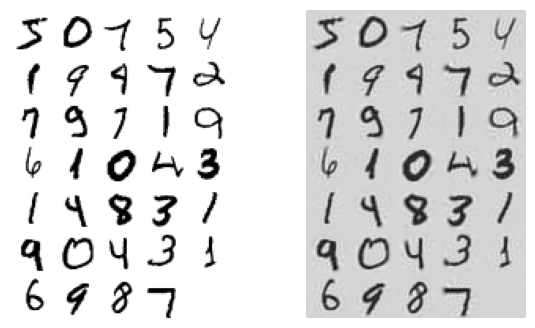

In [10]:
# Reconstruct the original data
X_recovered = pca.inverse_transform(X_reduced_mnist)

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty), int))
    for row in range(n_rows):
        r_images = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(r_images, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = "binary", **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_mnist[::2100]) # Original
plt.subplot(122)
plot_digits(X_recovered[::2100]) # Recovered
plt.show()

### Incremental PCA

In [11]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154) # 154 components for 95% variance from earlier
for X_batch in np.array_split(X_mnist, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced_inc_pca = inc_pca.transform(X_mnist)

### Randomized PCA

In [12]:
pca_randomized = PCA(n_components=154, svd_solver='randomized', random_state=42)
X_reduced_randomized = pca_randomized.fit_transform(X_mnist)

##Kernel PCA

In [13]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, fit_inverse_transform=True, random_state=42)
X_reduced_rbf = rbf_pca.fit_transform(X)

poly_pca = KernelPCA(n_components=2, kernel="poly", degree=3, coef0=1, random_state=42)
X_reduced_poly = poly_pca.fit_transform(X)

sigmoid_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, random_state=42)
X_reduced_sigmoid = sigmoid_pca.fit_transform(X)

### Selecting a Kernel and Tuning Hyperparameters

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression(solver="lbfgs"))
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X, y) # X and y from make_moons

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf']}])

In [15]:
grid_search.best_params_

{'kpca__gamma': np.float64(0.03222222222222222), 'kpca__kernel': 'rbf'}

##LLE (Locally Linear Embedding)

In [16]:
from sklearn.manifold import LocallyLinearEmbedding

# Generate Swiss Roll dataset
from sklearn.datasets import make_swiss_roll
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

# Apply LLE
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X_swiss)

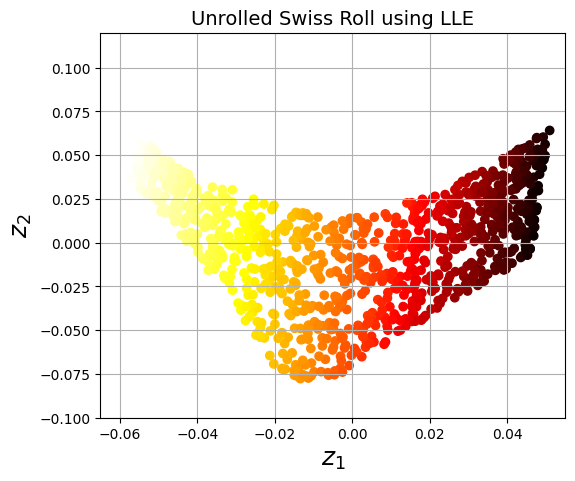

In [17]:
plt.figure(figsize=(6, 5))
plt.title("Unrolled Swiss Roll using LLE", fontsize=14)
plt.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel(r"$z_1$", fontsize=18)
plt.ylabel(r"$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()